# Travel Guide ChatBot

The Travel Guide Chatbot is a chatbot designed to provide meaningful, real-time conversational support to users seeking information related to travel planning and travel logistics. Its purpose is to streamline the travel experience by answering queries regarding questions like visa requirements, transport options, trip booking, and many other related questions. By offering interactive guidance, the chatbot helps users make informed decisions throughout their journey.

It is trained on the dataset acuired on huggingface via: https://huggingface.co/datasets/bitext/Bitext-travel-llm-chatbot-training-dataset

The following are the steps for its implementation

## 1. Installing Necessary Packages

In [1]:
!pip install datasets -q
!pip install gradio
!pip install evaluate -q
!pip install bert_score -q
!pip install rouge_score -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Importing The Necessary Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, DatasetDict, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import re
from evaluate import load
from tqdm.auto import tqdm
import evaluate
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
import numpy as np
import nltk

## 3. Loading The Dataset And Exploring

In [5]:
# Loading the as a pandas DataFrame for easy EDA

df = pd.read_csv("hf://datasets/bitext/Bitext-travel-llm-chatbot-training-dataset/bitext-travel-llm-chatbot-training-dataset.csv")
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,instruction,intent,category,tags,response
0,I want to know about my checked carry-on bagga...,check_baggage_allowance,BAGGAGE,BCIL,"To find out your checked baggage allowance, pl..."
1,I'm looking for information about my checked c...,check_baggage_allowance,BAGGAGE,BCLQZ,To check the details of your checked baggage a...
2,I'm looking for information about my fucking c...,check_baggage_allowance,BAGGAGE,BCILW,"To find out your checked baggage allowance, pl..."
3,I have to see the fuking checked carry-on bagg...,check_baggage_allowance,BAGGAGE,BCILPWZ,"To review your checked baggage allowance, plea..."
4,need to see the fucking checkedcarry-on baggag...,check_baggage_allowance,BAGGAGE,BCILQWZ,"To check your baggage allowance, please follow..."


In [6]:
# Getting the general overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31658 entries, 0 to 31657
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  31658 non-null  object
 1   intent       31658 non-null  object
 2   category     31658 non-null  object
 3   tags         31658 non-null  object
 4   response     31658 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


In [7]:
# Checking for the duplicates
print(df.duplicated().sum())

10


In [8]:
# Verifying for missing values per column
missing_values = df.isnull().sum()
print(missing_values)

instruction    0
intent         0
category       0
tags           0
response       0
dtype: int64


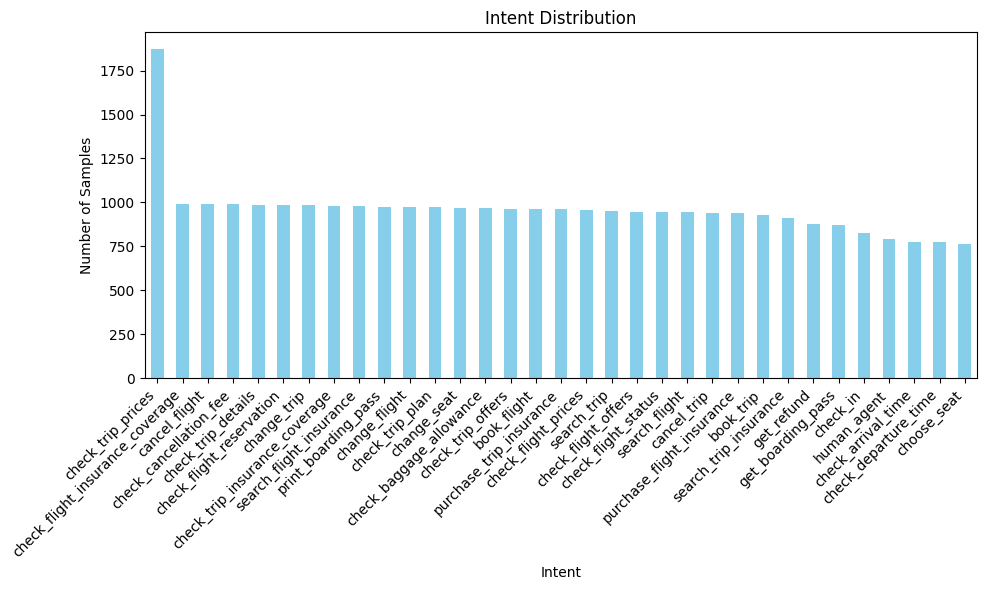

In [9]:
'''
Count the frequency of each intent to understand
well the dataset and visualize the range of the questions mostly asked in
the dataset and visualize the range of the questions mostly asked
'''

intent_counts = df['intent'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='bar', color='skyblue')
plt.title('Intent Distribution')
plt.xlabel('Intent')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Intent_plot.jpg')
plt.show()


### Findings

1. The dataset has enough data (31658 rows) that can be used to train the model well and make it able to learn semantics and adapt to the domain
2. The data has not many duplicates which ensures its variety.
3. Looking at the intent histogram, it shows that the moel will be able to cover quite a good number of different intents since they are many in the dataset and will be able to provide assistance in that domain.

## 4.  Preprocessing/Data Normalization And Tokenization

In [10]:
# Dropping the duplicates
df.drop_duplicates(inplace=True)

In [11]:
# Converting the dataset into a huggingface dataset for the pre_trained models
dataset = Dataset.from_pandas(df)

In [12]:
# Splitting the dataset into training and validation sets
split_ratio = 0.9

train_test_split = dataset.train_test_split(test_size=(1 - split_ratio), seed=42)
dataset = DatasetDict({"train": train_test_split["train"], "validation": train_test_split["test"]})

print(dataset)

print(dataset['train'][0])  # Example conversation

DatasetDict({
    train: Dataset({
        features: ['instruction', 'intent', 'category', 'tags', 'response', '__index_level_0__'],
        num_rows: 28483
    })
    validation: Dataset({
        features: ['instruction', 'intent', 'category', 'tags', 'response', '__index_level_0__'],
        num_rows: 3165
    })
})
{'instruction': 'I want to search some fucking flights, where can I do it?', 'intent': 'search_flight', 'category': 'FLIGHT', 'tags': 'BCIMW', 'response': "To locate a flight from {{ORIGIN_CITY}} to {{DESTINATION_CITY}}, please proceed with the following methodical instructions:\n\n1. Navigate to {{WEBSITE_URL}}.\n2. Input {{ORIGIN_CITY}} into the 'Departure' field.\n3. Input {{DESTINATION_CITY}} into the 'Arrival' field.\n4. Choose the desired dates for your journey.\n5. Press the {{SEARCH_BUTTON}}.\n\nFollowing these steps will enable you to review a compilation of flight options available for travel from {{ORIGIN_CITY}} to {{DESTINATION_CITY}}.", '__index_level_0__': 

In [13]:
# Preprocessing and normalizing the dataset
def normalize_input(text):
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\?\.,!]', '', text)
    return text

# Tokenizing the dataset to generate model retraining inputs

tokenizer = T5Tokenizer.from_pretrained("t5-small")  # Loading the appropriate tokenizer for t5-small

def preprocess_function(examples):
    inputs = [f"generate response for intent: {intent}: {normalize_input(instr)}"
              for intent, instr in zip(examples["intent"], examples["instruction"])]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["response"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
tokenized_dataset.save_to_disk("/content/drive/MyDrive/Travel_Guide_ChatBot/tokenized_dataset")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/28483 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/3165 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/28483 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3165 [00:00<?, ? examples/s]

## 5. Pre_trained Model Loading, Arguments Definition And Training

In [14]:
# Load T5-small model for  easy computation
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define training arguments optimized for Colab memory usage
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Travel_Guide_ChatBot/results",  # Directory for saving model checkpoints
    num_train_epochs=3,  # Three epochs for optimal balance of performance and efficiency
    per_device_train_batch_size=8,  # Batch size constrained by Colab memory
    per_device_eval_batch_size=16,  # Larger eval batch for faster validation
    warmup_steps=100,  # Gradual learning rate increase for stability
    weight_decay=0.01,  # Regularization to prevent overfitting
    learning_rate=2e-5,  # Baseline learning rate for initial training
    logging_dir="/content/drive/MyDrive/Travel_Guide_ChatBot/logs",  # Directory for training logs
    logging_steps=10,  # Log progress every 10 steps
    save_steps=200,  # Save checkpoints every 200 steps
    save_total_limit=1,  # Keep only the best model
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save after each epoch
    load_best_model_at_end=True,  # Use the best model based on validation loss
    fp16=True if torch.cuda.is_available() else False,  # Mixed precision for memory efficiency
    gradient_accumulation_steps=2,  # Effective batch size of 16 for memory optimization
    report_to="none"  # Disable logging to external services
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
)

# Train model
trainer.train()
baseline_logs = trainer.state.log_history.copy()  # Save logs BEFORE fine-tuning
baseline_loss = trainer.evaluate()["eval_loss"]
# Evaluate and compare learning rates
baseline_loss = trainer.evaluate()["eval_loss"]



config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.063700,0.829408
2,0.879900,0.668738
3,0.861800,0.631964


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


## 6. Finetuning The Model

In [15]:
# Fine-tune with a higher learning rate
training_args.learning_rate = 5e-5
finetune_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"]
)

finetune_trainer.train()
tuned_logs = finetune_trainer.state.log_history.copy()
tuned_loss = finetune_trainer.evaluate()["eval_loss"]
tuned_loss = trainer.evaluate()["eval_loss"]


Epoch,Training Loss,Validation Loss
1,0.574500,0.423356
2,0.503100,0.373615
3,0.501400,0.361837


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


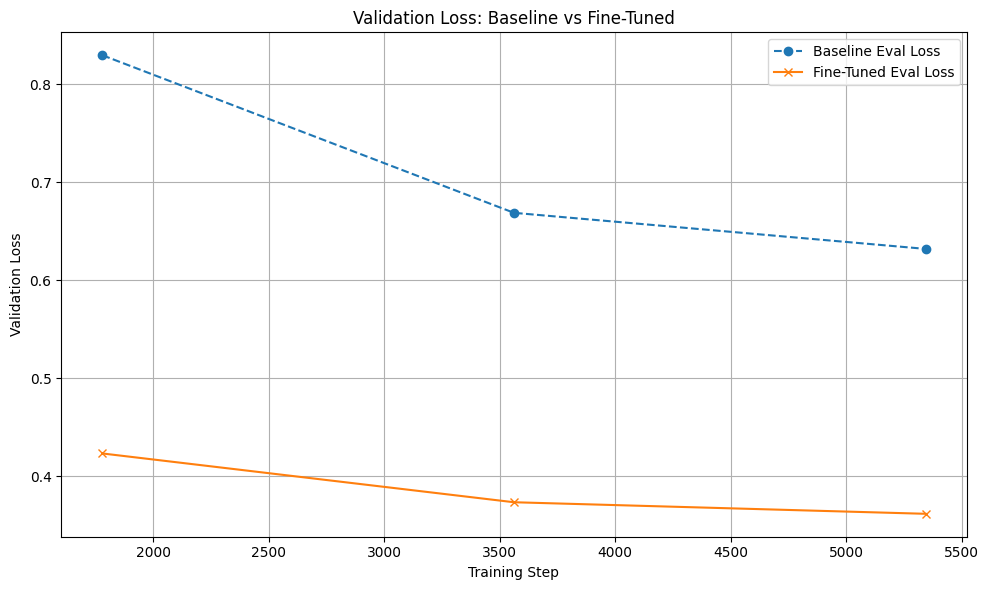

In [29]:
# Convert logs to DataFrames
df_baseline = pd.DataFrame(baseline_logs)
df_tuned = pd.DataFrame(tuned_logs)

# Extract eval_loss for plotting
baseline_steps = df_baseline[df_baseline["eval_loss"].notna()]
tuned_steps = df_tuned[df_tuned["eval_loss"].notna()]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(baseline_steps["step"], baseline_steps["eval_loss"], label="Baseline Eval Loss", linestyle='--', marker='o')
plt.plot(tuned_steps["step"], tuned_steps["eval_loss"], label="Fine-Tuned Eval Loss", linestyle='-', marker='x')
plt.xlabel("Training Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss: Baseline vs Fine-Tuned")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_plot.jpg')
plt.show()


## 7. Saving The Finetuned Model

In [17]:
# Save final model
model.save_pretrained('/content/drive/MyDrive/Travel_Guide_ChatBot/travel_chatbot_model', safe_serialization=False)
tokenizer.save_pretrained('/content/drive/MyDrive/Travel_Guide_ChatBot/travel_chatbot_model')

('/content/drive/MyDrive/Travel_Guide_ChatBot/travel_chatbot_model/tokenizer_config.json',
 '/content/drive/MyDrive/Travel_Guide_ChatBot/travel_chatbot_model/special_tokens_map.json',
 '/content/drive/MyDrive/Travel_Guide_ChatBot/travel_chatbot_model/spiece.model',
 '/content/drive/MyDrive/Travel_Guide_ChatBot/travel_chatbot_model/added_tokens.json')

In [18]:
# Print training results
print(f"Initial Loss: {baseline_loss:.2f}")
print(f"Tuned Loss: {tuned_loss:.2f}")

Initial Loss: 0.63
Tuned Loss: 0.36


## 8. Querry Testing

In [33]:
# Defining the functions that will take in querries, process them and return answers

# Loading the model and used tokenizer fot t5-small

tokenizer = T5Tokenizer.from_pretrained('/content/drive/MyDrive/Travel_Guide_ChatBot/travel_chatbot_model')
model = T5ForConditionalGeneration.from_pretrained('/content/drive/MyDrive/Travel_Guide_ChatBot/travel_chatbot_model')

# Move model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to proccessing the querry
def normalize_input(text):
    """Normalize text: lowercase, strip spaces, remove special chars."""
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\?\.,!]', '', text)
    return text

# Function to format the response
def capitalize_response(response):
    """Capitalize the first letter of sentences for readability."""
    sentences = response.split(". ")
    unique_sentences = []
    for s in sentences:
        if s and s not in unique_sentences:
            unique_sentences.append(s.capitalize())
    return ". ".join(unique_sentences)

# Function to feed  the tokenized inputs and decode the response
def test_query(query):
    """Test chatbot response for a given query."""
    query_lower = normalize_input(query)
    input_text = f"generate response: Current query: {query_lower}"
    input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).input_ids.to(device) # Move input_ids to the same device as the model
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=190,
            repetition_penalty=1.5,
        )
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return capitalize_response(response)

In [34]:
#  Testing with sample queries
test_queries = [
    "how to apply for a travel visa",
    "I need to know cheapest flights"
]
for q in test_queries:
    print(f"Query: {q}\nResponse: {test_query(q)}\n")

Query: how to apply for a travel visa
Response: To apply for a travel visa, please follow these steps: 1. Visit website_url and navigate to the travel section. 2. Fill in your travel details including departure city, arrival city, and travel dates. 3. Examine the available travel options and choose the one that best fits your requirements. 4. Press the search button to access the available travel options. 5. Select the search option to view the available travel options. Should you require further assistance, our team is available to assist you with any difficulties, do not hesitate to contact

Query: I need to know cheapest flights
Response: To find the cheapest flights for your journey, please follow these steps: 1. Visit website_url and sign in to your account. 2. Navigate to the checkin_section section. 3. Input your departure city in the origin_city field. 4. Choose the dates you wish to travel along with the number of passengers. 5. Press the search_button to retrieve the availabl

## 9. Evaluation The Model Using BERTSore, F1, ROUGE-L, BLEU Score, And Perplexity

In [21]:
# Load model & tokenizer

model_path = "/content/drive/MyDrive/Travel_Guide_ChatBot/travel_chatbot_model"
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Move model to correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare small eval subset
eval_data = tokenized_dataset["validation"].select(range(200))  # Use validation set and feel free to increase the sample size

# Decode predictions and references
predictions = []
references = []

for sample in tqdm(eval_data):
    input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(device)
    attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0).to(device)

    with torch.no_grad():
        # Added attention_mask to the generate method
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Decode the labels (reference answers)
    label = tokenizer.decode(sample["labels"], skip_special_tokens=True)


    predictions.append(pred)
    references.append(label)

  0%|          | 0/200 [00:00<?, ?it/s]

In [22]:
# Load the BERTScore evaluator
bertscore = load("bertscore")

# Compute BERTScore
results = bertscore.compute(
    predictions=predictions,
    references=references,
    lang="en"
)

print(f"\n Mean BERTScore F1: {sum(results['f1']) / len(results['f1']):.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Mean BERTScore F1: 0.9704


In [ ]:
# Load other evaluation metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
f1_metric = evaluate.load("f1")

In [24]:
# BLEU
bleu_result = bleu.compute(predictions=predictions, references=[[r] for r in references])
print(f"BLEU Score: {bleu_result['bleu']:.4f}")

# ROUGE
rouge_result = rouge.compute(predictions=predictions, references=references)
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")


BLEU Score: 0.6543
ROUGE-L: 0.7673


In [25]:
# calculating the perplexity
eval_results = trainer.evaluate()
eval_loss = eval_results["eval_loss"]
perplexity = torch.exp(torch.tensor(eval_loss))
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 1.44


In [30]:
# Computing the F1 Scores
# Download the specific resource needed for tokenization
nltk.download('punkt_tab')


def compute_f1_scores(preds, refs):
    f1_scores = []

    for pred, ref in zip(preds, refs):
        pred_tokens = set(word_tokenize(pred.lower()))
        ref_tokens = set(word_tokenize(ref.lower()))

        common = pred_tokens.intersection(ref_tokens)
        if len(common) == 0:
            f1_scores.append(0)
            continue

        precision = len(common) / len(pred_tokens)
        recall = len(common) / len(ref_tokens)
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)

    return np.mean(f1_scores)

f1_text_score = compute_f1_scores(predictions, references)
print(f"Text-overlap F1 Score: {f1_text_score:.4f}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Text-overlap F1 Score: 0.7849


## Overall Findings

1.  A huge effect of finetuning the model: The loss dropping from 0.63 to 0.36 indicates that the model learned meaningful patterns from the training data during fine-tuning.

  A loss reduction meant that the model's output was getting closer to the target answers in the dataset.
  Using a moderately high learning rate (5e-5) helped the model converge quickly without instability.

2. BLEU Score,  ROUGE-L,  Perplexity, F1 Score, and BERTScore:

  A BLEU score of 0.65 illustrated that the model captured phrasing and structure close to human responses. This showed that answers are not random or overly generic replies.

  A ROUGE-L score of 0.77 also showed that generated answers include most of the key information from reference answers, therefore, preserving semantic completeness while answering.

  A Perplexity of 1.44 measured how confident the model was in its predictions, which is an indicator that it learned.

  An F1 Score: 0.7849 showed that the answers are accurately matching relevant portions of the reference outputs.

  And finally, a BERTScore of 0.97 illustrated that generated responses are semantically nearly identical to the references. The chatbot understands the meaning and context of the question deeply, even when rephrasing the answer differently.

Overall,  the model is semantically aligned with the ground truth (dataset references), and it's not just copying words, but understanding and generating coherent meaning.


## 11. Gradio Deployment

In [27]:
!pip install gradio

In [31]:
import gradio as gr

# Define the Gradio interface function
def generate_response(query):
    """Generate chatbot response for a given query."""
    return test_query(query)  # Uses the test_query function defined earlier

# Create the Gradio interface
iface = gr.Interface(
    fn=generate_response,  # Function to call
    inputs=gr.Textbox(label="Enter your query", placeholder="Ask something...", lines=2),  # Input text box
    outputs=gr.Textbox(label="Response"),  # Output text box
    title="Travel Guide Chatbot",  # Title of the interface
    description="This is a chatbot that helps with travel-related queries. Ask anything!",  # Description of the interface
    theme=gr.themes.Soft()
)

# Launch the Gradio interface
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2186c1c18dd04314a6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
